# Validation Check

In [12]:
# load libraries
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numerapi import NumerAPI
from utils.api_keys import PUBLIC_ID, SECRET_KEY

In [13]:
# instantiate api & check for round
napi = NumerAPI(public_id=PUBLIC_ID, secret_key=SECRET_KEY)
current_round = napi.get_current_round()
print(f"Current round #: {current_round}")

Current round #: 324


In [14]:
# era corr function
def compute_corr_by_era(val_df, model_list, corr_method):
    df_list = []
    for m in model_list:
        r = val_df.groupby("era")[["target", m]].corr(method=corr_method).iloc[0::2, -1]
        df = pd.DataFrame(r)
        df_list.append(r)
    df_all = pd.concat(df_list, axis=1).dropna().reset_index()
    return df_all.drop("level_1", axis=1).set_index("era")

---
# Load validation datesets

In [15]:
# read validation set
validation = pd.read_parquet('data/validation.parquet', columns=["era", "target"]).dropna()

In [16]:
# file names
file_list = [
    "baseline", "foxhound", "deadcell", "deadcellv2", "cobra", "beautybeast",
    "skulls", "desperado", "desperadov2", "desperadov3", "gaia", "terra"
]

In [17]:
# join val pred files
val_list = []

for file in file_list:
    df = pd.read_csv(f"predictions/dh_{file}_val_preds.csv").set_index("id")
    val_list.append(df)

val = pd.concat(val_list, axis=1, join="inner")
val.columns = file_list

val.shape

(2214309, 12)

In [18]:
# join together
df = validation.merge(val, left_index=True, right_index=True)

In [19]:
# create averagejoe model
df["averagejoe"] = df["target"].mean() + np.random.rand(len(df.index)) / 100

In [20]:
# view data
df.head()

,era,target,baseline,foxhound,deadcell,deadcellv2,cobra,beautybeast,skulls,desperado,desperadov2,desperadov3,gaia,terra,averagejoe
id,,,,,,,,,,,,,,,
n000101811a8a843,0575,0.50,0.412901,0.129399,0.083253,0.160654,0.021482,0.318132,0.167181,0.103099,0.489464,0.075441,0.115393,0.640852,0.508038
n001e1318d5072ac,0575,0.00,0.737532,0.439920,0.511249,0.523757,0.757503,0.534279,0.809435,0.669596,0.503853,0.598711,0.496547,0.555339,0.504470
n002a9c5ab785cbb,0575,0.50,0.331627,0.834567,0.442349,0.297312,0.753014,0.554719,0.417338,0.654255,0.504113,0.793791,0.733283,0.832084,0.504504
n002ccf6d0e8c5ad,0575,0.25,0.779140,0.929344,0.899369,0.817130,0.966998,0.969571,0.968021,0.952201,0.512295,0.948171,0.834736,0.889336,0.503769
n0051ab821295c29,0575,0.50,0.613398,0.169555,0.265132,0.474896,0.082942,0.412966,0.364280,0.205035,0.490011,0.126249,0.290528,0.106378,0.504293


---
# Get correlation by era

In [21]:
# models
lgbm_model_names = ["baseline", "foxhound", "deadcell", "cobra", "beautybeast", "skulls", "desperadov3"]
dnn_model_names = ["baseline", "gaia", "terra"]
dev_model_names = ["baseline", "deadcellv2", "desperado", "desperadov2", "averagejoe"]

In [22]:
# get corrs
lgbm_pearson_corr = compute_corr_by_era(val_df=df, model_list=lgbm_model_names, corr_method="pearson")
lgbm_spearman_corr = compute_corr_by_era(val_df=df, model_list=lgbm_model_names, corr_method="spearman")

dnn_pearson_corr = compute_corr_by_era(val_df=df, model_list=dnn_model_names, corr_method="pearson")
dnn_spearman_corr = compute_corr_by_era(val_df=df, model_list=dnn_model_names, corr_method="spearman")

dev_pearson_corr = compute_corr_by_era(val_df=df, model_list=dev_model_names, corr_method="pearson")
dev_spearman_corr = compute_corr_by_era(val_df=df, model_list=dev_model_names, corr_method="spearman")

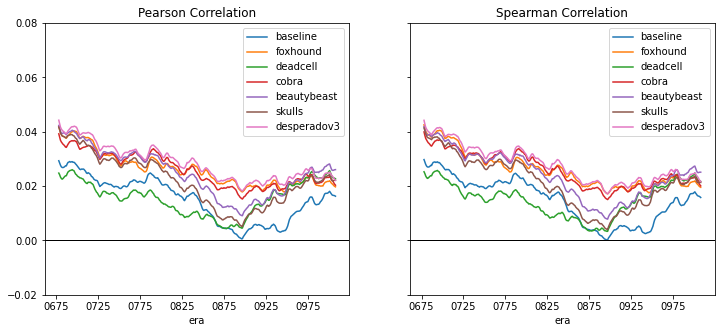

In [23]:
# correlation plots
ROLLING_FACTOR = 52 * 2

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 5))
lgbm_pearson_corr.rolling(ROLLING_FACTOR).mean().plot(ax=axes[0]);
lgbm_spearman_corr.rolling(ROLLING_FACTOR).mean().plot(ax=axes[1]);
axes[0].set_title("Pearson Correlation")
axes[0].axhline(0, color ='black', linewidth=1)
axes[0].set_ylim(-0.02, 0.08)
axes[1].set_title("Spearman Correlation")
axes[1].axhline(0, color ='black', linewidth=1)
plt.show()

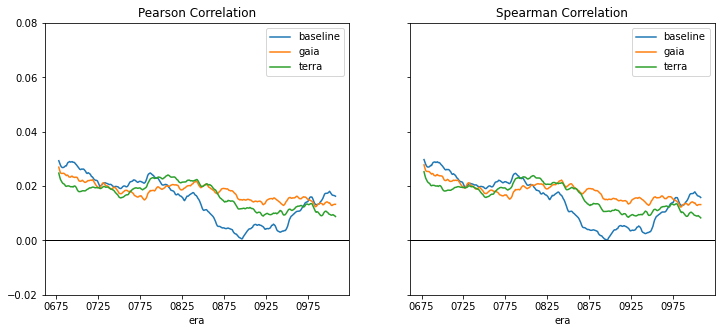

In [24]:
# correlation plots
ROLLING_FACTOR = 52 * 2

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 5))
dnn_pearson_corr.rolling(ROLLING_FACTOR).mean().plot(ax=axes[0]);
dnn_spearman_corr.rolling(ROLLING_FACTOR).mean().plot(ax=axes[1]);
axes[0].set_title("Pearson Correlation")
axes[0].axhline(0, color ='black', linewidth=1)
axes[0].set_ylim(-0.02, 0.08)
axes[1].set_title("Spearman Correlation")
axes[1].axhline(0, color ='black', linewidth=1)
plt.show()

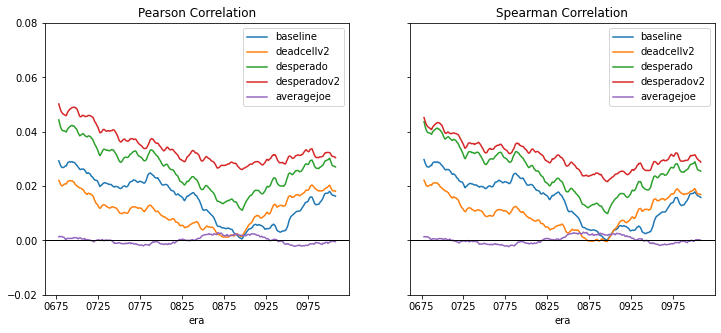

In [25]:
# correlation plots
ROLLING_FACTOR = 52 * 2

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 5))
dev_pearson_corr.rolling(ROLLING_FACTOR).mean().plot(ax=axes[0]);
dev_spearman_corr.rolling(ROLLING_FACTOR).mean().plot(ax=axes[1]);
axes[0].set_title("Pearson Correlation")
axes[0].set_ylim(-0.02, 0.08)
axes[0].axhline(0, color ='black', linewidth=1)
axes[1].set_title("Spearman Correlation")
axes[1].axhline(0, color ='black', linewidth=1)
plt.show()

---
# Net corr scores by models

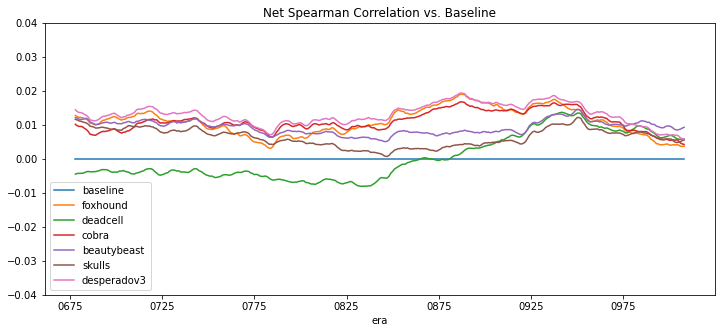

In [26]:
# net spearman vs. baseline for lgbm models
plt.figure(figsize=(12, 5))
for m in lgbm_model_names:
    (lgbm_spearman_corr[m] - lgbm_spearman_corr["baseline"]).rolling(ROLLING_FACTOR).mean().plot()
plt.legend(lgbm_model_names)
plt.ylim(-0.04, 0.04)
plt.title("Net Spearman Correlation vs. Baseline")
plt.show()

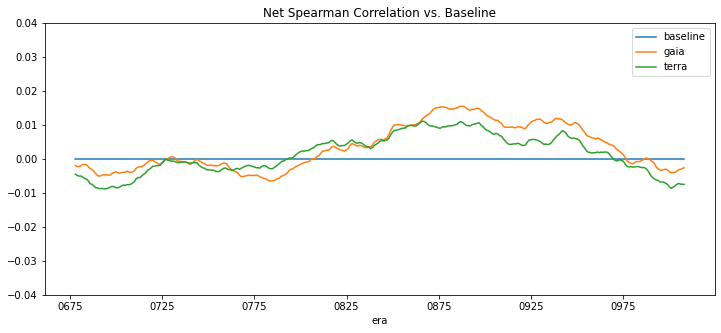

In [27]:
# net spearman vs. baseline for dnn models
plt.figure(figsize=(12, 5))
for m in dnn_model_names:
    (dnn_spearman_corr[m] - dnn_spearman_corr["baseline"]).rolling(ROLLING_FACTOR).mean().plot()
plt.legend(dnn_model_names)
plt.ylim(-0.04, 0.04)
plt.title("Net Spearman Correlation vs. Baseline")
plt.show()

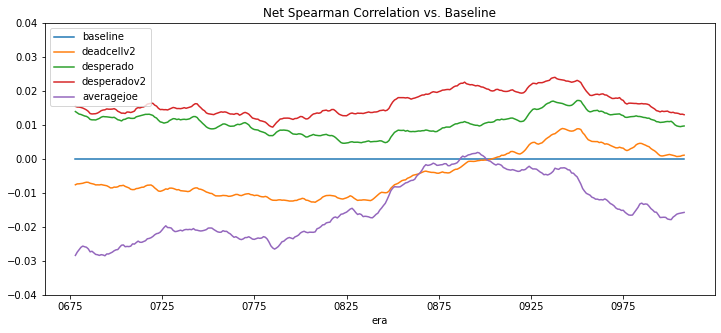

In [28]:
# net spearman vs. baseline for dev models
plt.figure(figsize=(12, 5))
for m in dev_model_names:
    (dev_spearman_corr[m] - dev_spearman_corr["baseline"]).rolling(ROLLING_FACTOR).mean().plot()
plt.legend(dev_model_names)
plt.ylim(-0.04, 0.04)
plt.title("Net Spearman Correlation vs. Baseline")
plt.show()

---
# Get Sharp Ratio by models

In [29]:
# compute sharpe ratio (lgbm models)
lgbm_sharpe_df = pd.concat([
    (lgbm_pearson_corr.mean() / lgbm_pearson_corr.std()),
    (lgbm_spearman_corr.mean() / lgbm_spearman_corr.std())], axis=1)

lgbm_sharpe_df.columns = ["sharpe_pearson", "sharpe_spearman"]
round(lgbm_sharpe_df, 2)

,sharpe_pearson,sharpe_spearman
baseline,0.63,0.61
foxhound,1.00,0.98
deadcell,0.62,0.60
cobra,0.97,0.97
beautybeast,0.93,0.89
skulls,0.80,0.77
desperadov3,1.03,1.01


In [30]:
# compute sharpe ratio (dnn models)
dnn_sharpe_df = pd.concat([
    (dnn_pearson_corr.mean() / dnn_pearson_corr.std()),
    (dnn_spearman_corr.mean() / dnn_spearman_corr.std())], axis=1)

dnn_sharpe_df.columns = ["sharpe_pearson", "sharpe_spearman"]
round(dnn_sharpe_df, 2)

,sharpe_pearson,sharpe_spearman
baseline,0.63,0.61
gaia,0.82,0.84
terra,0.81,0.79


In [31]:
# compute sharpe ratio (dev models)
dev_sharpe_df = pd.concat([
    (dev_pearson_corr.mean() / dev_pearson_corr.std()),
    (dev_spearman_corr.mean() / dev_spearman_corr.std())], axis=1)

dev_sharpe_df.columns = ["sharpe_pearson", "sharpe_spearman"]
round(dev_sharpe_df, 2)

,sharpe_pearson,sharpe_spearman
baseline,0.63,0.61
deadcellv2,0.52,0.48
desperado,0.90,0.86
desperadov2,1.32,1.22
averagejoe,0.02,0.03


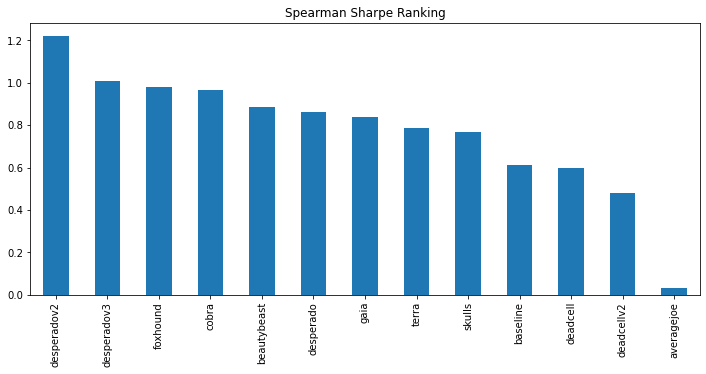

In [32]:
# plot
sharpe_df = pd.concat([lgbm_sharpe_df, dnn_sharpe_df.drop("baseline"), dev_sharpe_df.drop("baseline")])
sharpe_df["sharpe_spearman"].sort_values(ascending=False).plot.bar(
    title="Spearman Sharpe Ranking", 
    figsize=(12, 5)
);

---
# Submit for validation diagnosis

In [33]:
# read model name json file
with open("data/model_names.json", "r") as f:
    model_names = json.load(f)

model_names

{'dh_foxhound': '4d9bcd2c-69cb-4e17-a3f3-a4b2530cbcb8',
 'dh_deadcell': 'df8e47ff-b123-42a1-8145-a55b19be6a99',
 'dh_cobra': 'fe228762-f88a-4d09-9478-d02ae849a58a',
 'dh_beautybeast': '48c649b4-068b-483f-b370-770d55247b8d',
 'dh_skulls': '1296c746-5f1d-44af-a197-7f21e933dac9',
 'dh_desperado': '547bed40-6905-4f13-945d-de77d99e0487',
 'dh_gaia': '23d7378d-a7b4-425b-b67e-77b4bc3d4ccd',
 'dh_terra': '50c76ce7-3e69-47ec-85e4-6dbc6c42969c'}

In [34]:
# # single model submission
# model_to_submit = "dh_gaia"

# napi.upload_diagnostics(
#     file_path=f"predictions/{model_to_submit}_val_preds.csv",
#     model_id=model_names[f"{model_to_submit}"]
# )

In [35]:
# # submit validation predictions for diagnosis
# for item in model_names.items():
#     print(f"Submitting validation predictions for: {item[0]}...")
#     napi.upload_diagnostics(
#         file_path=f"predictions/{item[0]}_val_preds.csv",
#         model_id=item[1]
#     )